# Um Pipeline de Supervisão Fraca aplicado à Classificação de Incidentes em Infraestrutura de TI

## 1. Introdução

A gestão da infraestrutura de Tecnologia da Informação (TI envolve, de forma contínua, o monitoramento e a resposta a eventos críticos que podem comprometer a disponibilidade, a segurança e o desempenho dos serviços. Entre os incidentes mais recorrentes estão falhas em servidores, picos de utilização de CPU, tentativas de acesso não autorizado e problemas relacionados a rotinas de backup.

Em ambientes corporativos de médio e grande porte — especialmente aqueles com baixos níveis de maturidade em processos e conformidade — o volume e a complexidade desses incidentes tornam a tarefa de categorização uma atividade onerosa, propensa a falhas humanas e difícil de escalar manualmente.

Diante desse cenário, a aplicação de técnicas de inteligência artificial se mostra uma alternativa promissora para automatizar, de maneira eficaz, a classificação desses eventos, contribuindo para a agilidade na tomada de decisão e na mitigação de riscos operacionais.

O paradigma de Supervisão Fraca possibilita a geração de rótulos a partir de dados originalmente não anotados, utilizando funções programáticas denominadas *Labeling Functions*. Apesar de esses rótulos poderem conter certo nível de ruído, a agregação probabilística de múltiplas funções permite a geração de anotações mais confiáveis. Esses rótulos, posteriormente, servem como base para o treinamento de modelos de aprendizado de máquina capazes de realizar classificações com desempenho satisfatório, mesmo na ausência de grandes volumes de dados rotulados manualmente.

# 2. Estrutura

O pipeline está estruturado em quatro etapas fundamentais:


**Criação das Funções de Rotulagem**

Especialistas no domínio desenvolvem múltiplas funções de rotulagem, cada uma projetada para capturar aspectos específicos da tarefa-alvo. Essas funções podem se sobrepor ou até mesmo se contradizer. A diversidade entre elas contribui para cobrir diferentes perspectivas dos dados.

**Rotulagem dos Dados**

Cada função de rotulagem é aplicada ao conjunto de dados não rotulados, resultando em um conjunto de rótulos candidatos. Como essas funções não são perfeitas, os rótulos gerados contêm certo nível de ruído.

**Agregação dos Rótulos**

Os rótulos candidatos são combinados por meio de um modelo de agregação que aprende tanto a confiabilidade quanto as possíveis dependências entre as funções de rotulagem. Um método comum consiste em modelar o rótulo final como uma função probabilística.

**Treinamento do Modelo**

Os rótulos agregados, juntamente com os dados originais, são utilizados para treinar um modelo de aprendizado de máquina na tarefa-alvo. A qualidade desses rótulos influencia diretamente o desempenho do modelo.

Cada etapa será implementada objetivando a compreensão e a possibilidade de replicação do processo para outros projetos.

# 3. Criação do Dataset

Para a aplicação prática, foi gerado um dataset fictício com 5000 incidentes de TI. Cada incidente é um texto curto descrevendo um evento comum de infraestrutura, como falhas de servidor, picos de CPU, backups concluídos com sucesso ou com falha, entre outros. Esse formato foi escolhido por ser semelhante aos logs que encontramos em sistemas de monitoramento como Zabbix e Nagios, por exemplo.

O arquivo dataset está no formato ".csv".
Amostras de entradas do dataset:

```
4996              Falha no backup
4997                     Erro 500
4998         Falha em atualização
4999  Indisponibilidade de e-mail

```

In [125]:
# Instalar e Importar bibliotecas necessárias
!pip install snorkel
import re
import pandas as pd
import numpy as np
from snorkel.labeling import labeling_function
from snorkel.labeling.model.label_model import LabelModel
import matplotlib.pyplot as plt

# Carregar o dataset
dataset_path = "./incidentes_ti.csv"
df = pd.read_csv(dataset_path)

# Visualizar o dataset
print(df)


                        incidente
0            Vazamento de memória
1                     Erro de DNS
2                 Falha no backup
3           Falha de autenticação
4          Erro no banco de dados
...                           ...
4995        Travamento do sistema
4996              Falha no backup
4997                     Erro 500
4998         Falha em atualização
4999  Indisponibilidade de e-mail

[5000 rows x 1 columns]


# 4. Etapa I - Criação das Funções de Rotulagem (Labeling Functions)

No contexto do dataset escolhido para este laboratório, cada função de rotulagem foi desenvolvida para capturar um aspecto específico dos eventos e classificá-los retornando um rótulo equivalente a CRÍTICO (1), NÃO CRÍTICO (0), ou ABSTENÇÃO (-1).

Abaixo, apresento as quatro funções de rotulagem criadas:

# lf_erro_500 - Erro 500 ou Erro Genérico

Esta função captura qualquer evento que mencione um erro específico (HTTP 500) ou um erro genérico. Isso é útil para detectar problemas críticos em servidores web ou aplicações.

# lf_uso_cpu - Uso de CPU Acima do Limite

Em ambientes de infraestrutura, picos de CPU podem indicar sobrecarga de servidores, problemas em aplicações ou ataques DDoS. Esta função identifica eventos que mencionem o uso de CPU acima de 80%.

# lf_backup - Backup e Sucesso/Falha

A integridade dos backups é fundamental em qualquer infraestrutura. Esta função diferencia entre backups bem-sucedidos e falhas no processo.

# lf_acesso_nao_autorizado - Acesso Não Autorizado

Eventos de acesso não autorizado ou tentativas de login suspeitas são marcadores claros de incidentes críticos. Esta função foca em identificar essas ocorrências.

In [126]:
# Definição das classes
CRITICO = 1
NAO_CRITICO = 0
ABSTENCAO = -1

# Função de rotulagem para erros genéricos
def lf_erro_500(x):
    """
    Detecta mensagens que contêm "erro 500" ou "erro" de forma geral.
    """
    if re.search(r"erro\s*\d{3}|erro\b", x.incidente.lower()):
        return CRITICO
    return ABSTENCAO

# Função de rotulagem baseada em uso de CPU
def lf_uso_cpu(x):
    """
    Detecta uso elevado de CPU acima de 80%.
    """
    # Captura padrões de CPU acima de 80%
    match = re.search(r"cpu.*(\d{2})%", x.incidente.lower())
    if match:
        uso_cpu = int(match.group(1))
        if uso_cpu >= 80:
            return CRITICO
        else:
            return NAO_CRITICO
    return ABSTENCAO

# Função de rotulagem para backup
def lf_backup(x):
    """
    Identifica ocorrências relacionadas a backup e seu estado (falha ou sucesso).
    """
    if re.search(r"backup", x.incidente.lower()):
        if re.search(r"sem\s+problemas|sem erros", x.incidente.lower()):
            return NAO_CRITICO
        else:
            return CRITICO
    return ABSTENCAO

# Função de rotulagem para acesso não autorizado
def lf_acesso_nao_autorizado(x):
    """
    Detecta tentativas de acesso não autorizado ou logins suspeitos.
    """
    if re.search(r"não autorizado|login suspeito", x.incidente.lower()):
        return CRITICO
    return ABSTENCAO

# Lista de funções de rotulagem
lfs = [lf_erro_500, lf_uso_cpu, lf_backup, lf_acesso_nao_autorizado]

# Aplicar as funções de rotulagem
for lf in lfs:
    lf_name = lf.__name__
    df[lf_name] = df.apply(lf, axis=1)

L = df[[lf.__name__ for lf in lfs]].values

# Exibir a estrutura do DataFrame após a rotulagem
print(df)

                        incidente  lf_erro_500  lf_uso_cpu  lf_backup  \
0            Vazamento de memória           -1          -1         -1   
1                     Erro de DNS            1          -1         -1   
2                 Falha no backup           -1          -1          1   
3           Falha de autenticação           -1          -1         -1   
4          Erro no banco de dados            1          -1         -1   
...                           ...          ...         ...        ...   
4995        Travamento do sistema           -1          -1         -1   
4996              Falha no backup           -1          -1          1   
4997                     Erro 500            1          -1         -1   
4998         Falha em atualização           -1          -1         -1   
4999  Indisponibilidade de e-mail           -1          -1         -1   

      lf_acesso_nao_autorizado  
0                           -1  
1                           -1  
2                       

# 5. Etapa 2 - Agregação dos Rótulos com Snorkel

Após aplicar as funções de rotulagem, geramos uma matriz L onde cada coluna representa uma função de rotulagem e cada linha um incidente. Os valores são 1 (CRÍTICO), 0 (NÃO CRÍTICO) ou -1 (ABSTENÇÃO).

Exemplo de matriz L:

Para combinar esses rótulos, utilizamos o LabelModel do Snorkel. Esse modelo pondera os rótulos com base na confiabilidade esperada de cada função, gerando um rótulo final mais robusto.

100%|██████████| 500/500 [00:00<00:00, 703.17epoch/s]


                        incidente  lf_erro_500  lf_uso_cpu  lf_backup  \
0            Vazamento de memória           -1          -1         -1   
1                     Erro de DNS            1          -1         -1   
2                 Falha no backup           -1          -1          1   
3           Falha de autenticação           -1          -1         -1   
4          Erro no banco de dados            1          -1         -1   
...                           ...          ...         ...        ...   
4995        Travamento do sistema           -1          -1         -1   
4996              Falha no backup           -1          -1          1   
4997                     Erro 500            1          -1         -1   
4998         Falha em atualização           -1          -1         -1   
4999  Indisponibilidade de e-mail           -1          -1         -1   

      lf_acesso_nao_autorizado  label  
0                           -1     -1  
1                           -1      1  
2  

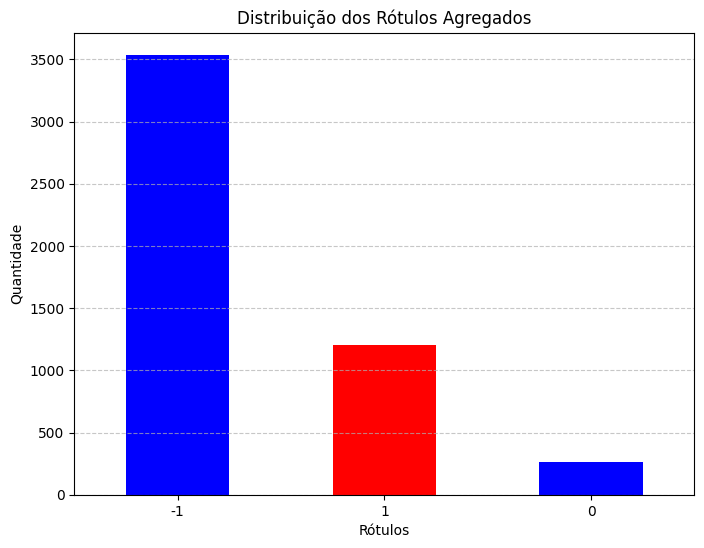

In [127]:
# Modelo de agregação
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L, n_epochs=500, log_freq=200)

# Rótulos finais
df["label"] = label_model.predict(L)

# Visualizar os rótulos finais
print(df)

# Analisar a distribuição dos rótulos para cada função de rotulagem
for lf in lfs:
    lf_name = lf.__name__
    print(f"Distribuição dos rótulos para {lf_name}:")
    print(df[lf_name].value_counts())
    print("\n")

# Contar os rótulos CRÍTICO
total_critico = (df["label"] == 1).sum()
print(f"Total de rótulos CRÍTICO (1): {total_critico}")

import matplotlib.pyplot as plt

# Contagem dos rótulos
label_counts = df["label"].value_counts()

# Plotar a distribuição
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red'])
plt.title("Distribuição dos Rótulos Agregados")
plt.xlabel("Rótulos")
plt.ylabel("Quantidade")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# 6. Etapa III - Vetorização dos Textos e Treinamento do Modelo

A vetorização transforma textos em representações numéricas, viabilizando o uso em modelos de aprendizado de máquina. Neste trabalho utilizamos o método TF-IDF (Term Frequency - Inverse Document Frequency), que atribui pesos maiores às palavras mais relevantes em cada documento, destacando termos importantes para melhorar a precisão na classificação dos eventos.

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Separar dados de treino e teste
X = df["incidente"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

# Vetorização de texto
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Treinamento do modelo
model = LogisticRegression()
model.fit(X_train_vec, y_train)

LogisticRegression()

A regressão logística é um modelo utilizado para classificar eventos em duas categorias, como "crítico" ou "não crítico", calculando a probabilidade com base nos dados disponíveis. Por ser fácil de aplicar e interpretar, ela é bastante útil como uma primeira abordagem prática de machine learning para resolver problemas de monitoramento e classificação em TI.

# 7. Etapa IV - Avaliação do Modelo

A avaliação é realizada com a acurácia, matriz de confusão e o relatório de classificação:

In [129]:
# Avaliação do modelo
y_pred = model.predict(X_test_vec)
print("Acurácia:")
print(accuracy_score(y_test, y_pred))
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

Acurácia:
1.0
Relatório de Classificação:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1052
           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00       371

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

Matriz de Confusão:
[[1052    0    0]
 [   0   77    0]
 [   0    0  371]]


# 9. Conclusão

Com os resultados em mãos, vimos que o modelo acertou 100% das previsões no conjunto de teste: todas as métricas (acurácia, precision, recall e f1-score) ficaram perfeitas para cada classe. A matriz de confusão mostra que não houve nenhum erro de classificação. Isso indica que o modelo se ajustou muito bem aos dados que usamos, mas é importante ficar atento a possíveis sinais de overfitting antes de aplicar o modelo em novos cenários.

Uma das razões para esse desempenho pode ser que as classes estão bem separadas e as características escolhidas representam bem cada tipo de incidente. Por outro lado, pode ser que o teste tenha ficado muito parecido com o treino, o que também gera resultados quase perfeitos. Para confirmar se o modelo realmente generaliza bem, seria legal testar com um conjunto de dados totalmente novo.